In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [2]:
conn = sqlite3.connect("../db.sqlite3")
query = """
    SELECT restaurant_order.id, datetime, restaurant_product.id, price, name, quantity
    FROM restaurant_order
    JOIN restaurant_orderitem ON restaurant_order.id = restaurant_orderitem.order_id
    JOIN restaurant_product ON restaurant_orderitem.product_id = restaurant_product.id
"""
result = conn.execute(query)
rows = result.fetchall()
conn.close()

columns = ["order_id", "date_of_order", "product_id", "price", "name", "quantity"]
df = pd.DataFrame(rows, columns=columns)
df.to_csv("data.csv", index=False)

new_df = pd.read_csv("data.csv")
new_df.head()

,order_id,date_of_order,product_id,price,name,quantity
0,1,2019-08-03 20:25:00,6,0.80,Plain Papadum,2
1,1,2019-08-03 20:25:00,240,12.95,King Prawn Balti,1
2,1,2019-08-03 20:25:00,19,2.95,Garlic Naan,1
3,1,2019-08-03 20:25:00,36,3.95,Mushroom Rice,1
4,1,2019-08-03 20:25:00,111,8.95,Paneer Tikka Masala,1


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

Text(0.5, 1.0, 'Top 10 positions by quantity')

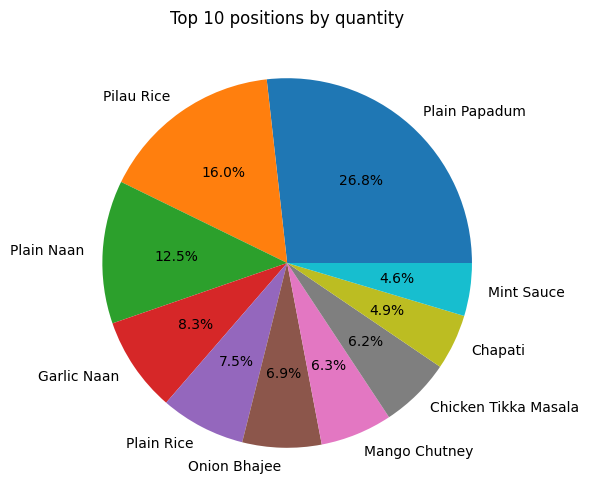

In [49]:
top_sold_products = new_df.groupby("product_id")["quantity"].sum().sort_values(ascending=False).head(10)
top_sold_df = pd.DataFrame({"product_id": top_sold_products.index, "total_quantity": top_sold_products.values})
top_sold_df["percentage"] = (top_sold_df["total_quantity"] / top_sold_df["total_quantity"].sum()) * 100

new_df_top = new_df[new_df["product_id"].isin(top_sold_products.index)]
top_sold_df = pd.merge(top_sold_df, new_df_top[["product_id", "name"]].drop_duplicates(), on="product_id")

plt.figure(figsize=(10, 6))
plt.pie(top_sold_df["percentage"], labels=top_sold_df["name"], autopct="%1.1f%%")
plt.title("Top 10 positions by quantity")

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

Text(0.5, 1.0, 'Top 10 positions by revenue')

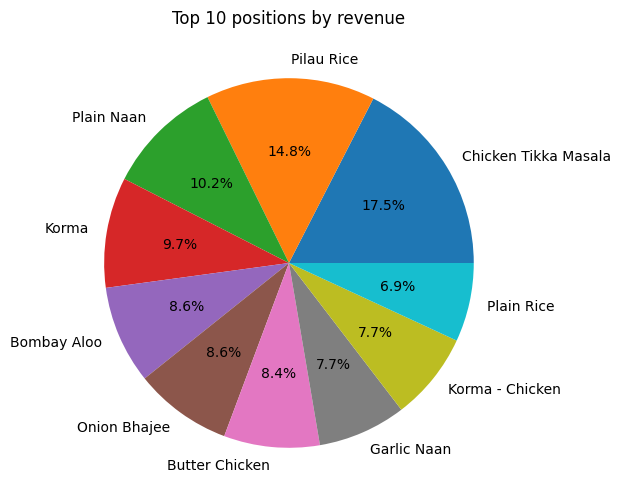

In [69]:
new_df["item_price"] = new_df["price"] * new_df["quantity"]
popular_products = new_df.groupby("product_id")["item_price"].sum().sort_values(ascending=False).head(10)
popular_df = pd.DataFrame({"product_id": popular_products.index, "total_price": popular_products.values})
popular_df["percentage"] = (popular_df["total_price"] / popular_df["total_price"].sum()) * 100

df_pop_prod = new_df[new_df["product_id"].isin(popular_products.index)]
popular_df = pd.merge(popular_df, df_pop_prod[["product_id", "name"]].drop_duplicates(), on="product_id")

plt.figure(figsize=(10, 6))
plt.pie(popular_df["percentage"], labels=popular_df["name"], autopct="%1.1f%%")
plt.title("Top 10 positions by revenue")

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23')])

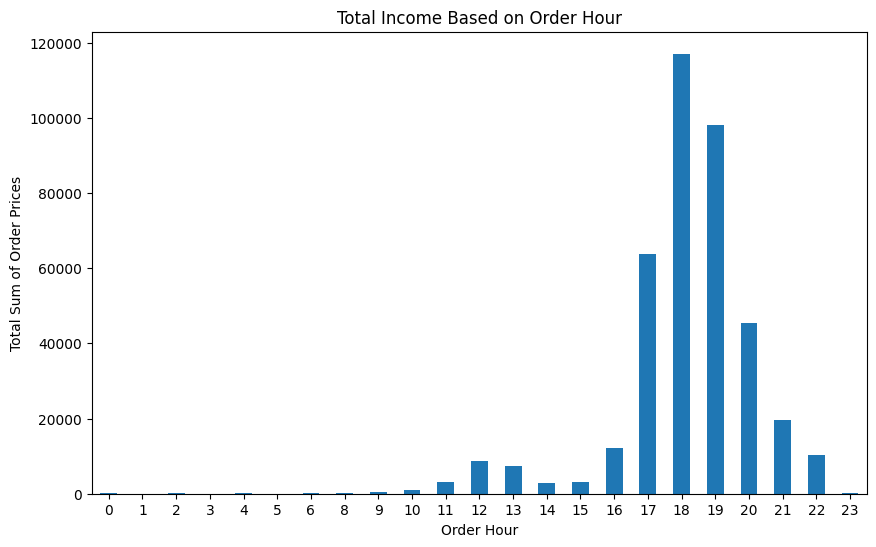

In [82]:
new_df["date_of_order"] = pd.to_datetime(new_df["date_of_order"])
new_df["hour_of_order"] = new_df["date_of_order"].dt.hour
hourly_income = new_df.groupby("hour_of_order")["price"].sum()

plt.figure(figsize=(10, 6))
hourly_income.plot(kind="bar")
plt.xlabel("Order Hour")
plt.ylabel("Total Sum of Order Prices")
plt.title("Total Income Based on Order Hour")
plt.xticks(rotation=0)

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

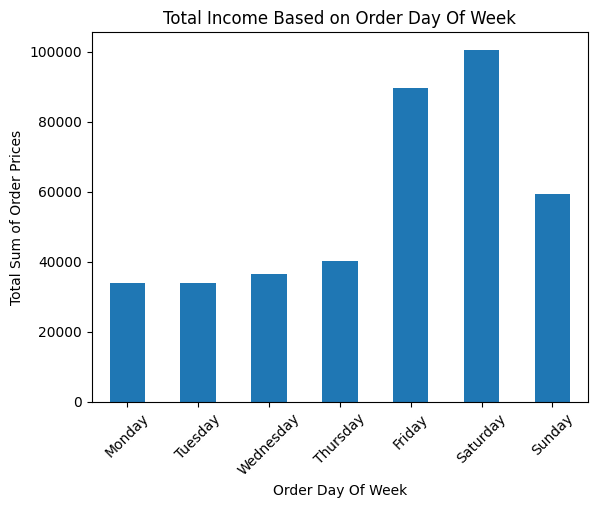

In [80]:
new_df["day_of_order"] = new_df["date_of_order"].dt.day_name()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
new_df["day_of_order"] = pd.Categorical(new_df["day_of_order"], categories=day_order, ordered=True)
daily_income = new_df.groupby("day_of_order", observed=False)["price"].sum()

daily_income.plot(kind="bar")
plt.xlabel("Order Day Of Week")
plt.ylabel("Total Sum of Order Prices")
plt.title("Total Income Based on Order Day Of Week")
plt.xticks(rotation=45)